In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
from sklearn import datasets
from sklearn import model_selection

## data upload

In [0]:
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=5,
    n_informative=5,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

(500, 5)


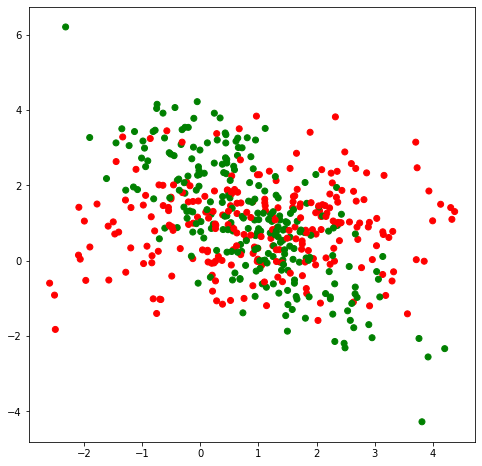

In [3]:
def plot_data(data, fig_size=(8,8)):
    colors = ListedColormap(['red', 'green'])
    light_colors = ListedColormap('lightcoral', 'lightblue')

    plt.figure(figsize=(8, 8))
    plt.scatter(
        list(map(lambda x: x[0], classification_data)),
        list(map(lambda x: x[1], classification_data)),
        c=classification_labels,
        cmap=colors
    )

    print(classification_data.shape)

plot_data(classification_data)

## functions analysis

In [4]:
def get_bootstrap(data, labels, n):
    n_samples = data.shape[0]
    bootstrap = []

    # by rows in the sample
    for i in range(n):
        b_data = np.zeros(data.shape)
        # print(b_data.shape)
        b_labels = np.zeros(labels.shape)
        # by columns in the sample 
        for j in range(n_samples):
            # shuffling index by random
            sample_index = random.randint(0, n_samples-1)
            # print(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))

    return bootstrap

get_bootstrap(classification_data, classification_labels, 3)

# for get_bootstrap(classification_data, classification_labels, 3):
## b_data.shape, b_labels.shape: [((500, 5), (500,)), ((500, 5), (500,)), ((500, 5), (500,))]

[(array([[ 4.30966802,  1.41268735, -0.64380591,  0.15203282,  0.96364015],
         [ 0.54036083,  2.25476975, -0.37352958,  0.65527413,  0.39919438],
         [ 0.9381159 ,  1.6386778 ,  1.11830997, -0.99646447,  1.81308175],
         ...,
         [ 1.33783805,  0.90132689,  0.95292952,  0.44131974,  2.29694031],
         [ 0.53895538,  0.24581103,  0.7489712 , -1.06674928,  0.72744109],
         [ 3.85333329, -0.01255664, -1.77261956,  0.56857145,  2.75587163]]),
  array([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
         1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
         1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0

In [0]:
def get_subsample(len_sample):
    # list of indixes from zero to len
    sample_indices = [i for i in range(len_sample)]
    # length of subsample as sqr root of the whole length
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    # shuffling the indices of the sample
    random.shuffle(sample_indices)

    for i in range(len_subsample):
        subsample.append(sample_indices.pop())

    return subsample

In [0]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # index of the feature comapred to threshold
        self.t = t # threshold value
        self.true_branch = true_branch # subsample in compliance with the condition in the node
        self.false_branch = false_branch # subsample not in compliance with the condition in the node

# base case node == leaf
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # qaunt of the objects of various classes
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        # print(classes)
        # predicting by majority
        prediction = max(classes, key=classes.get)
        # print(prediction)
        return prediction

# Leaf(classification_data, classification_labels)
## classes are {1: 249, 0: 251}
## prediction is 0

In [0]:
# calc the gini coefficient

def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        # print(classes[label])
        # print(p)
        impurity -= p ** 2

    return impurity

# gini(classification_labels)

In [0]:
# calc the quality 
def quality(left_labels, right_labels, current_gini):
    # samples elements in the left subtree
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# splitting dataset in the node
def split(data, labels, index, t):

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

# split(classification_data, classification_labels, 0, 0.3)

In [0]:
# find the best split

def find_best_split(data, labels):

    # min quant of objects in the node
    min_leaf = 1

    current_gini = gini(labels)

    best_quality, best_t, best_index = 0, None, None

    n_features = data.shape[1]

    # subsample size = sq root of the sample size
    subsample = get_subsample(n_features)

    for index in subsample:
        # getting only unique values of a feature
        t_values = np.unique([row[index] for row in data])
        # print(len(t_values))

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            # skipping splits with less than 5 objects within
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)

            # getting threshold with the max increase in quality
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# find_best_split(classification_data, classification_labels)

In [0]:
def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)

    # base case if not quality increase
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # building true & false subtrees recursively
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

# build_tree(classification_data, classification_labels)

In [0]:
# building random forest
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest

# random_forest(classification_data, classification_labels, 3)

In [0]:
# classification function
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        # print(answer)
        return answer

    # print(node.index)
    # print(obj[node.index])
    # print(node.t)
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# prediction for the sample by one tree
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)

    return classes

# prediction by trees' vote
def tree_vote(forest, data):

    # all prediction in a list
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    # list with predictions for the each of the objects
    predictions_per_object = list(zip(*predictions))

    # the preidction with the most of votes
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [0]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data,
    classification_labels,
    test_size=0.3,
    random_state=1
)

In [0]:
n_trees = 1

my_forest_1 = random_forest(train_data, train_labels, n_trees)

train_answers = tree_vote(my_forest_1, train_data)
test_answers = tree_vote(my_forest_1, test_data)
# print(len(train_answers))

## fit & predict

In [15]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(
    f'accuracy @train with {n_trees} trees: {train_accuracy:.3f}'
    )

print(
    f'accuracy @test with {n_trees} trees: {test_accuracy:.3f}'
    )

accuracy @train with 1 trees: 97.714
accuracy @test with 1 trees: 92.000


In [0]:
def eval_model(model, train_x, train_y, test_x, test_y, n_trees):

    my_model = model(train_data, train_labels, n_trees)

    train_answers = tree_vote(my_model, train_data)
    test_answers = tree_vote(my_model, test_data)

    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)

    print(
        f'accuracy @train with {n_trees} trees: {train_accuracy:.3f}'
        )

    print(
        f'accuracy @test with {n_trees} trees: {test_accuracy:.3f}'
        )
    
    return [train_accuracy, test_accuracy]

In [17]:
eval_model(
    random_forest,
    train_data, train_labels,
    test_data, test_labels,
    3
)

accuracy @train with 3 trees: 99.429
accuracy @test with 3 trees: 94.667


[99.42857142857143, 94.66666666666667]

In [18]:
eval_model(
    random_forest,
    train_data, train_labels,
    test_data, test_labels,
    10
)

accuracy @train with 10 trees: 100.000
accuracy @test with 10 trees: 97.333


[100.0, 97.33333333333334]

In [19]:
eval_model(
    random_forest,
    train_data, train_labels,
    test_data, test_labels,
    50
)

accuracy @train with 50 trees: 100.000
accuracy @test with 50 trees: 98.000


[100.0, 98.0]

#1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

(100, 2)


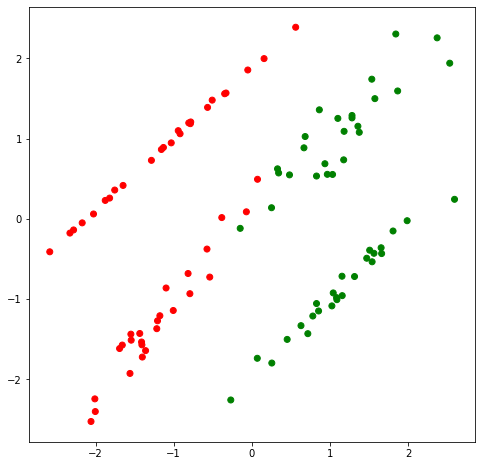

In [20]:
classification_data, classification_labels = datasets.make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=2,
    random_state=42
)

plot_data(classification_data)

In [0]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data,
    classification_labels,
    test_size=0.3,
    random_state=1
)

In [0]:
# function to het the accuracy and plot of the model
def visualize_forest(x_train, y_train, x_test, y_test, n_trees, ax=None, cmap='rainbow'):
    
    model = random_forest(x_train, y_train, n_trees)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    ax1.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=30, cmap=cmap,
                zorder=3)
    ax1.axis('tight')
    ax1.axis('off')
    ax1.set_title('@train')
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    z = np.array(tree_vote(model, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    n_classes = len(np.unique(y_train))
    contours = ax1.contourf(xx, yy, z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, 
                           zorder=1)

    ax2.set(xlim=xlim, ylim=ylim)

    ax2.scatter(x_test[:, 0], x_test[:, 1], c=y_test, s=30, cmap=cmap,
                zorder=3)
    ax2.axis('tight')
    ax2.axis('off')
    ax2.set_title('@test')
    xlim = ax2.get_xlim()
    ylim = ax2.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    
    z = np.array(tree_vote(model, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    n_classes = len(np.unique(y_test))
    contours = ax2.contourf(xx, yy, z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, 
                           zorder=1)

    ax2.set(xlim=xlim, ylim=ylim)

    train_answers = tree_vote(model, x_train)
    test_answers = tree_vote(model, x_test)

    train_accuracy = accuracy_metric(y_train, train_answers)
    test_accuracy = accuracy_metric(y_test, test_answers)

    print(
        f'accuracy @train: {train_accuracy:.3f}'
        )

    print(
        f'accuracy @test: {test_accuracy:.3f}'
    )

accuracy @train: 97.143
accuracy @test: 93.333


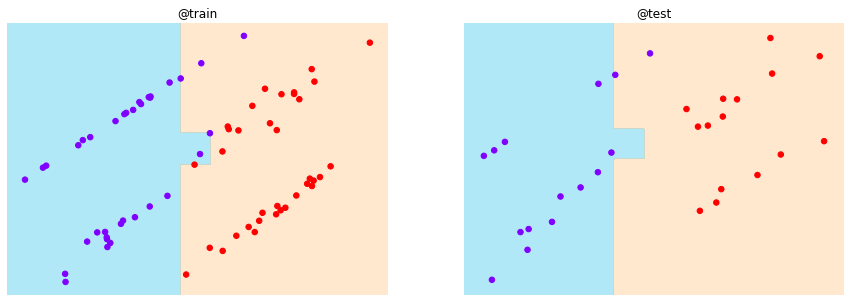

In [70]:
visualize_forest(train_data, train_labels, test_data, test_labels, 1)

accuracy @train: 100.000
accuracy @test: 93.333


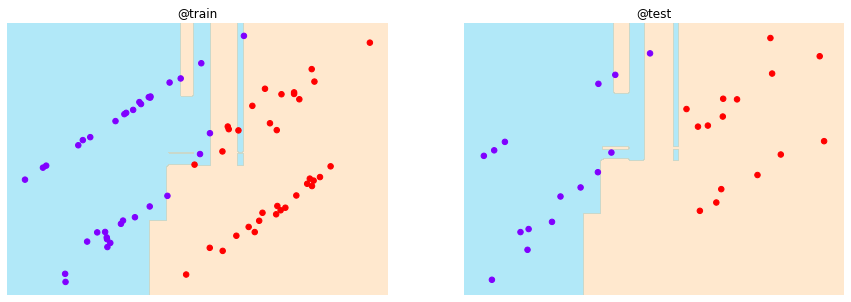

In [68]:
visualize_forest(train_data, train_labels, test_data, test_labels, 3)

accuracy @train: 100.000
accuracy @test: 100.000


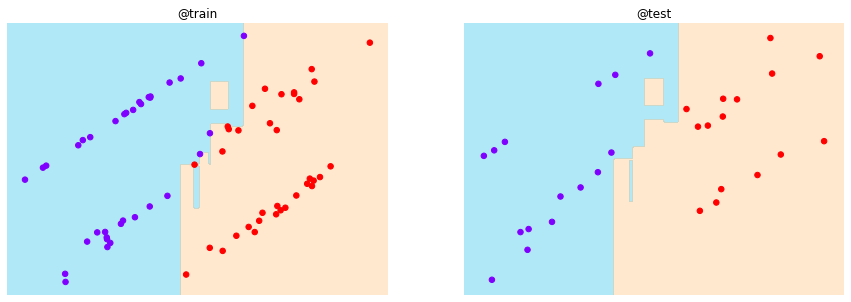

In [51]:
visualize_forest(train_data, train_labels, test_data, test_labels, 10)

accuracy @train: 100.000
accuracy @test: 96.667


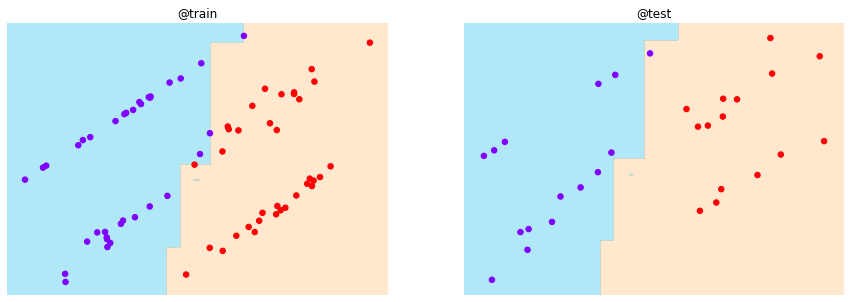

In [52]:
visualize_forest(train_data, train_labels, test_data, test_labels, 50)

на размерности 50 деревьев модель переобучилась

# 3. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [0]:
# calc the entropy coefficient
def entropy(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    entropy_coef = 1
    for label in classes:
        p = classes[label] / len(labels)
        entropy_coef -= np.sum(p * np.log2(p))

    return entropy_coef

# functions variables update:

def quality(left_labels, right_labels, current_entropy):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

def find_best_split(data, labels):

    min_leaf = 1
    current_entropy = entropy(labels)
    best_quality, best_t, best_index = 0, None, None
    n_features = data.shape[1]
    subsample = get_subsample(n_features)

    for index in subsample:
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)

            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


accuracy @train: 98.571
accuracy @test: 93.333


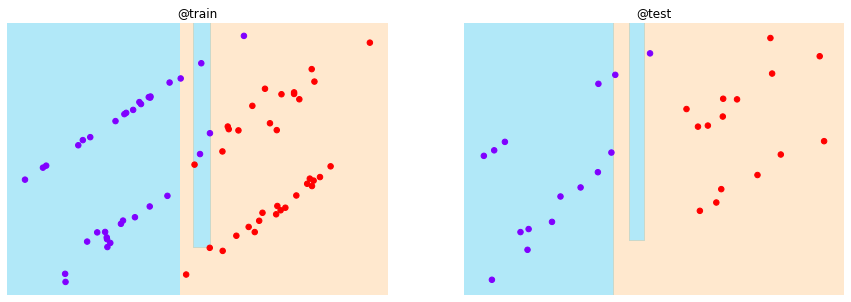

In [62]:
visualize_forest(train_data, train_labels, test_data, test_labels, 1)

accuracy @train: 95.714
accuracy @test: 96.667


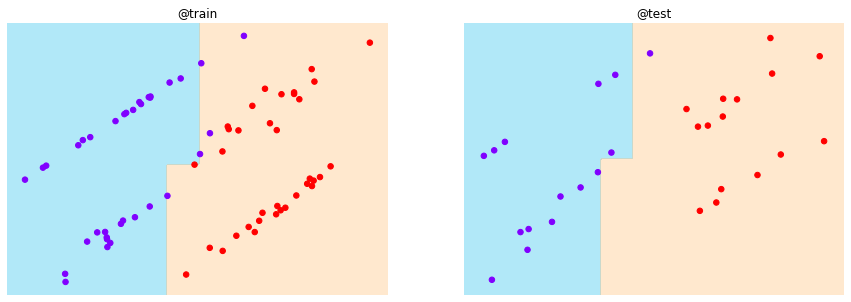

In [63]:
visualize_forest(train_data, train_labels, test_data, test_labels, 3)

accuracy @train: 98.571
accuracy @test: 96.667


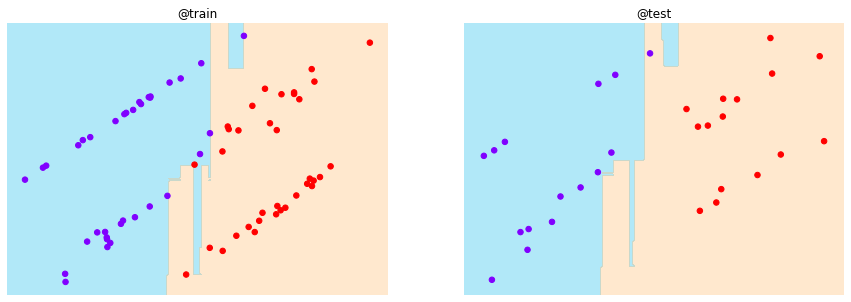

In [66]:
visualize_forest(train_data, train_labels, test_data, test_labels, 10)

accuracy @train: 100.000
accuracy @test: 96.667


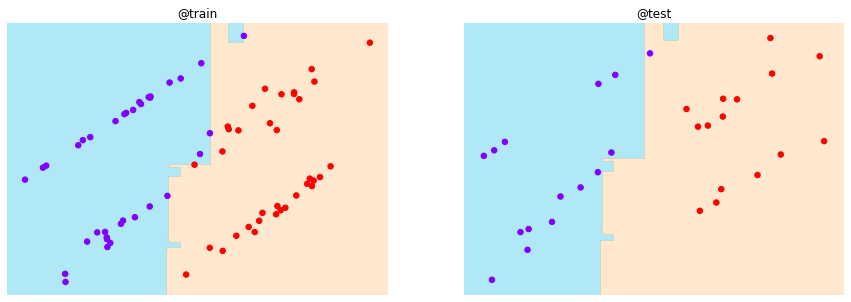

In [65]:
visualize_forest(train_data, train_labels, test_data, test_labels, 50)